# Path vs. ensemble inference from cytokinesis data for the effective Bessel process

In [2]:
import time, sys, os
import numpy as np
from numpy import linalg
import scipy.special as sp
from matplotlib import pyplot as plt

import random as rd
import pickle

import dynesty
from dynesty import plotting as dyplot

rstate = np.random.default_rng(5647)

#### utils

In [7]:
def compute_covmap(X,Y):
    #preallocation
    covdim = X.shape[1]
    corr=np.zeros((covdim,covdim))

    #compute covariance matrix with nan treatment
    for t1 in np.arange(covdim):
        for t2 in np.arange(covdim):
            x = X[:, t1]
            y = Y[:, t2]
            
            bad = ~np.logical_or(np.isnan(x), np.isnan(y))
            xnan = np.compress(bad, x)
            ynan = np.compress(bad, y)
            
            cov = np.mean((xnan-np.mean(xnan))*(ynan-np.mean(ynan)))
            corr[t1,t2] = cov
            
    return corr

####  inference functions

For more details on how to perform the inference go to the other notebook.

path inference functions

In [8]:
def prior_transform_withoutalpha(u):
    """prior transform for parameters gamma and D"""
    return u*np.array([1.0,1.0]) + np.array([0.0, 0.0])#u*np.array([1.0,1.0,0.00001]) + np.array([0.5, 0.0, -1.000005])#u*np.array([1.0,1.0,0.5]) + np.array([0.5, 0.0, -1.25])   #(u-0.5)*3#10. * (2. * u - 1.)

def bessel_force(gam, D, x):
    force = (D+gam)/x
    return force

def loglikelihood_array_bessel(p, x, dx, dt):
    gamma = p[0]
    D = p[1]
    
    var_p = 2*( D*dt) 
    norm = np.sqrt(np.pi * var_p )    
    singleLogLike_ar = - 0.5*((dx - bessel_force(gamma, D, x)*dt)**2) / var_p - 0.5*np.log(norm)      
    singleLogLike = np.nansum(singleLogLike_ar)
    if np.isinf(singleLogLike) or np.isnan(singleLogLike):
            loglike = -np.inf
    return singleLogLike

ensemble inference functions

In [9]:
def theory_mean_bessel(gam, D, x):
    return np.sqrt(2*D*x) * sp.gamma(gam/D +2)/sp.gamma(gam/D +3/2)
def theory_var_bessel(gam, D, x):
    return D * x * (3 + 2*gam/D - (2*sp.gamma(2 + gam/D)**2)/sp.gamma(3/2 + gam/D)**2)
def cov_bessel_single(gam, D, s, t):
    cov = (2*D*sp.gamma(2 + gam/D)**2 *(-np.sqrt(s*t) + np.sqrt(s) * t**(-2 - gam/D) * (-s + t)**(5/2 + gam/D)* sp.hyp2f1(2 + gam/D, 2 + gam/D, 3/2 + gam/D, s/t)))/sp.gamma(3/2 + gam/D)**2
    return cov 
def theory_cov_bessel(gam, D, t):    
    N = len(t)
    cov_array = np.zeros((N,N))
    
    for i in np.arange(N-1):
        s = t[i]
        s2 = t[i+1:]
        
        cov_row = cov_bessel_single(gam, D, s, s2)
        cov_array[i+1:, i] = cov_row
        cov_array[i, i+1:] = cov_row
        
        np.fill_diagonal(cov_array, theory_var_bessel(gam, D, t))
    
    return cov_array

In [10]:
def loglikelihood_bessel_mean_cov(p, mean_data, cov_data, deltat):
    '''Likelihood for ensemble inference, which is the method of moments. See more details in the main text.'''
    
    gamma = p[0]
    D = p[1]
    
    ### time vector
    t = np.arange(len(mean_data))*deltat
    
    ### calculate theory moments (this step could also be done with simulations if moments are not analytically accesible)
    ### currently we used covariance estimation for variance least squares, which is computationally nonsensical. 
    ### change at your discretion.
    mean_theory = theory_mean_bessel(gamma, D,t)
    #var_theory = theory_var_bessel(gamma, D, t)
    cov_theory = theory_cov_bessel(gamma, D,t)
    
    ### least squares
    lsq_mean = (mean_data - mean_theory)
    #lsq_var = (var_data - var_theory)
    #lsq_cov = (cov_data - cov_theory).flatten()
    lsq_var = (np.diagonal(cov_data) - np.diagonal(cov_theory))
    
    #std_mean = np.nanstd(lsq_mean)
    #std_var = np.nanstd(lsq_var)
    #std_cov = np.nanstd(lsq_cov)
    
    N_mean = len(lsq_mean)
    maskinf_mean = ~np.isinf(lsq_mean)
    maskinf_var = ~np.isinf(lsq_var)
    
    if (sum(np.isnan(lsq_mean))==N_mean) or (sum(np.isnan(lsq_var)) == N_mean):
        loglike = -np.inf
    else:
        loglike_mean = -0.5*np.nansum(lsq_mean**2)
        loglike_var = -0.5*np.nansum(lsq_var**2)
        #loglike_cov = -0.5*np.nansum(lsq_cov**2) 
        
        ### if you dont have the same number of datapoints, as here, you should correct for that e.g. when doing inference with the full covariance
        loglike = loglike_mean + loglike_var  #+ loglike_cov 
        
        if np.isinf(loglike) or np.isnan(loglike):
            loglike = -np.inf
    return loglike



#### subsampling inference code

In [11]:
def bootstrapping_sampling_serial(Nboot, N_trajs, deltat, timestep, xdata, dxdata, whichinference, savepath):
    '''
    Subsampling nested sampling runs with different number of trajectories and timesteps. 
    Can be trivially parallelized for HPC if needed.
    
    Nboot = how many subsamples
    N_trajs = how many trajectories
    deltat = timestep from simulation
    timestep = how many timesteps for inference
    xdata = trajectories
    dxdata = increment trajetories
    whichinference = inference type
    savepath = save markov chain object. choices: 'nosave' or 'path/to/results'
    '''
    
    Ndata = xdata.shape[1]
    if Ndata < N_trajs:
        print('ERROR: number of trajectories has to be less than data dimensionality')
        return 0
    idxs_data = list(np.arange(Ndata))
    
    for i in np.arange(Nboot):
        #mask = np.random.choice(idxs_data, N_trajs) # draw with replacement
        mask = rd.sample(idxs_data, N_trajs) # draw without replacement
        data = xdata[:, mask]
        ddata = dxdata[:, mask]
    
        if whichinference == 'ensemble_inference':
            cov_data = compute_covmap(np.transpose(data), np.transpose(data))
            mean_data = np.nanmean(data, axis = 1)
            #var_data = np.nanvar(x, axis = 1)
            sampler = dynesty.NestedSampler(loglikelihood_bessel_mean_cov, prior_transform_withoutalpha, 2, nlive=200,
                               rstate=rstate, 
                                logl_args=[mean_data, cov_data, deltat*timestep])
            sampler.run_nested(dlogz=0.05) 
            
        elif whichinference == 'path_inference': 
            ndim=2
            if timestep < 20: #want to start at 20*0.5 = 10 but for every timestep
                startanalyze = int(20/timestep)
            else:
                startanalyze = 1
            sampler = dynesty.NestedSampler(loglikelihood_array_bessel, prior_transform_withoutalpha, ndim, nlive=200,
                               rstate=rstate, 
                            logl_args=[data[startanalyze:,:], ddata[startanalyze:,:], deltat*timestep]) #want to start at startanalyze=20, 20*0.5 = 10 but for every timestep
            sampler.run_nested()
            
        else:
            print('ERROR: inference type does not exist. you can choose -path_inference- or -ensemble_inference- keywords.')
        
        if savepath != 'nosave':
            with open(os.path.join(savepath, 'sampler_besselinf401_type{}_Ntraj{}_deltat{}_timesteps{}_Nboot{}_bootnumber{}.pickle'.format(whichinference, N_trajs, deltat, timestep, Nboot, i)), 'wb') as handle:
                    pickle.dump(sampler, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return sampler


#### parameters and data

you need to generate a large ensemble with >50000 trajectories to properly do subsampling (code in /generateCytokinEnsemble/. We only provide a small test ensemble.

In [13]:
path_data = "generateCytokinEnsemble/"#"'path/to/data'
path_save = 'nosave' #or 'path/to/results'
Nbootstrap = 1 # how many subsamples
N_trajectories = 100 # how many trajectories
deltaT = 0.5 # timestep from simulation
Timesteps = 10 # how many timesteps for inference
inference_type = 'path_inference' #'ensemble_inference' 

In [14]:
loadts = np.load(os.path.join(path_data, "x_besselhighres.pickle"), allow_pickle=True)
loadts = loadts[:, :] # subsample ensemble further if needed
tsarr = loadts[::int(Timesteps),:]
x1 = np.roll(tsarr,-1,0)
dx = x1[:-1]-tsarr[:-1]
x = tsarr[:-1]


#### do inference and show result

In [17]:
### do inference with external options
smplr = bootstrapping_sampling_serial(int(Nbootstrap), int(N_trajectories), float(deltaT), int(Timesteps), x, dx, inference_type, path_save)



2235it [00:12, 174.73it/s, +200 | bound: 10 | nc: 1 | ncall: 10015 | eff(%): 24.809 | loglstar:   -inf < -1749.913 <    inf | logz: -1759.406 +/-  0.206 | dlogz:  0.001 >  0.209]


In [18]:
res = smplr.results
print('Keys:', res.keys(),'\n')  # accesible keys in the results object
res.summary()  # print summary

Keys: ['nlive', 'niter', 'ncall', 'eff', 'samples', 'blob', 'samples_id', 'samples_it', 'samples_u', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale'] 

Summary
nlive: 200
niter: 2235
ncall: 9815
eff(%): 24.809
logz: -1759.406 +/-  0.284


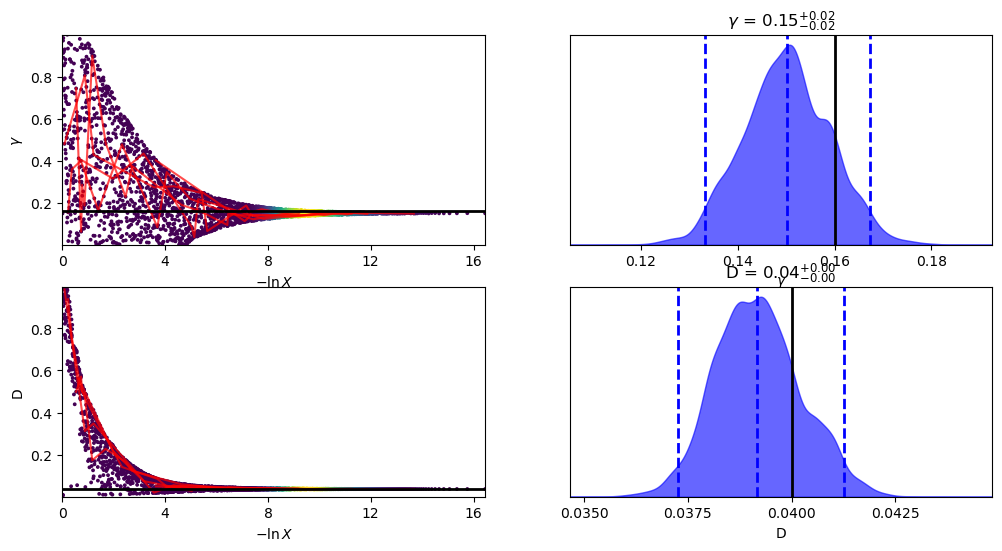

In [19]:
ptrue = [0.16,0.04,-1]

## plotting using dyplot from dynesty
fig, axes = dyplot.traceplot(res, 
                             truths=ptrue, 
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             labels = [r'$\gamma$', 'D', r'$\alpha$'],
                             connect_highlight=range(5))